Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/nyu_data/nyu_data/data/nyu2_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Using test folder: /content/nyu_data/nyu_data/data/nyu2_test


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loaded 654 test samples.
Loading weights:  None


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


Avg YOLOv8 Detection Inference Time: 0.0230 s

Avg Depth Inference Times:
MiDaS: 0.0175 s
DPT_Hybrid: 0.0395 s

Avg Depth Metrics (AbsRel, RMSE, RMSE_log, Δ<1.25, Δ<1.25^2, Δ<1.25^3):
MiDaS: [     1.2269      3.1923      1.3655     0.18624     0.34417     0.47944]
DPT_Hybrid: [      1.284      3.4111      1.1122     0.18474      0.3451     0.47887]


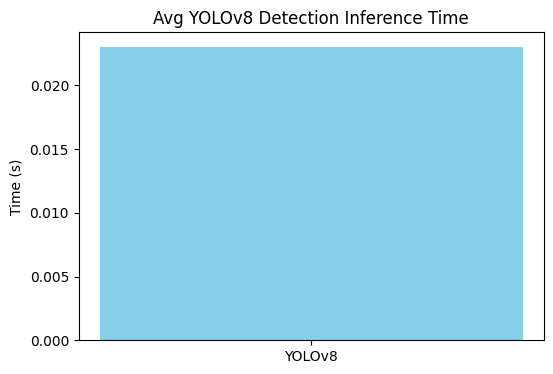

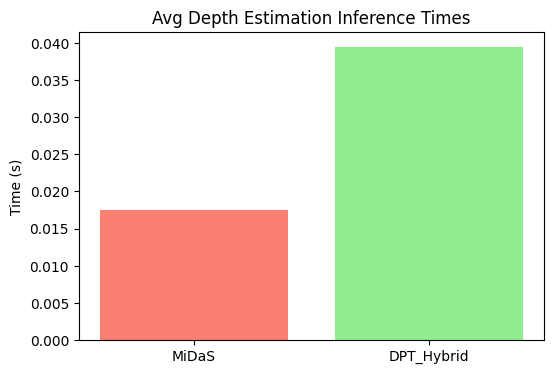

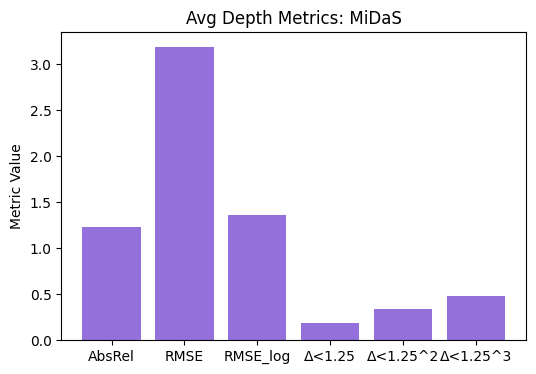

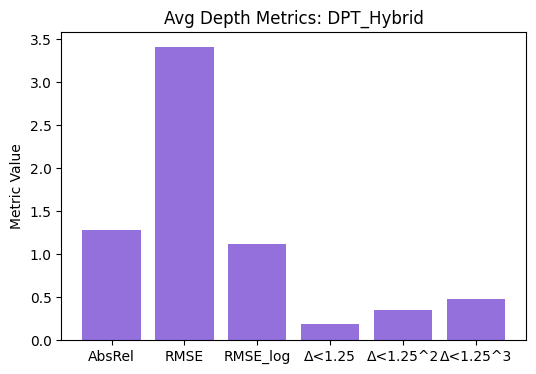

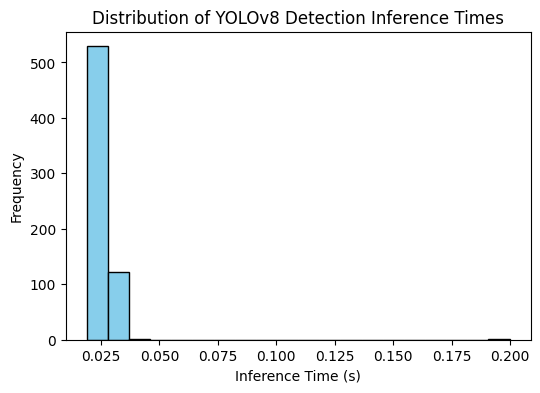

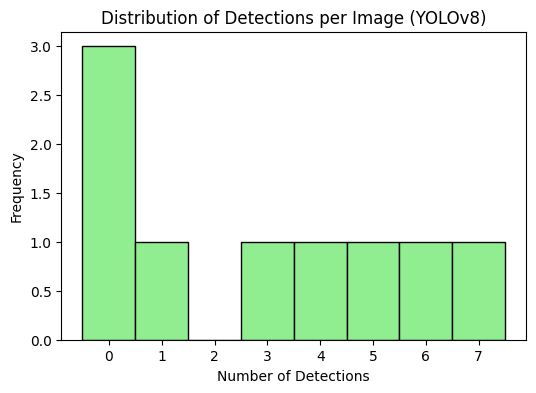

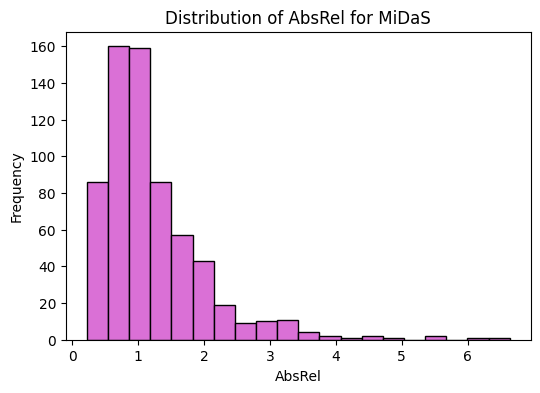

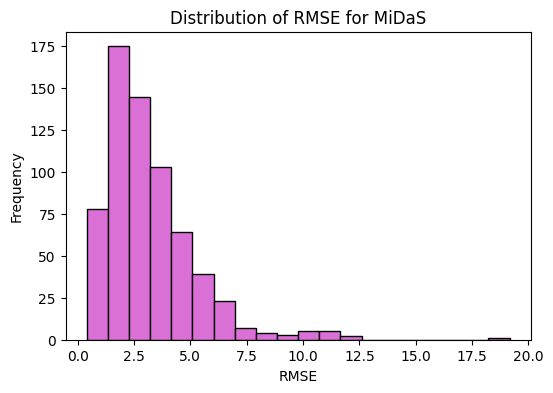

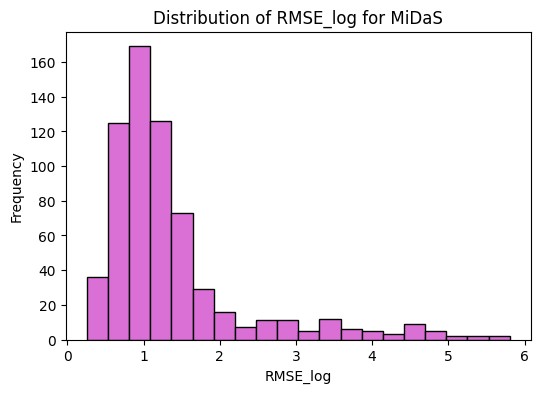

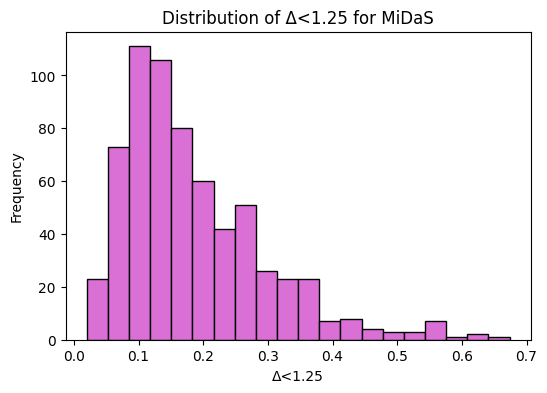

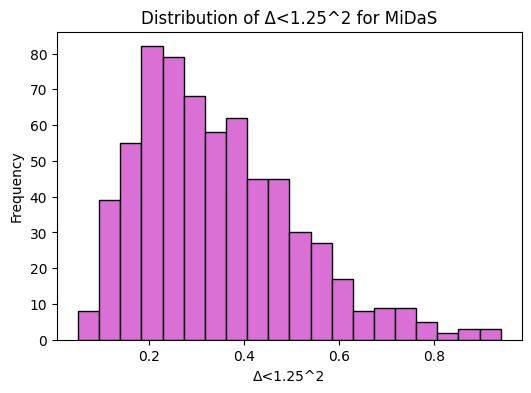

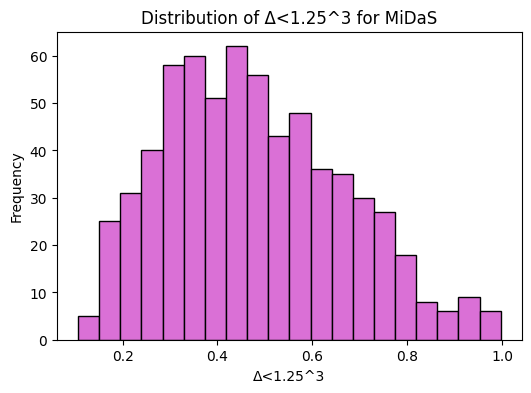

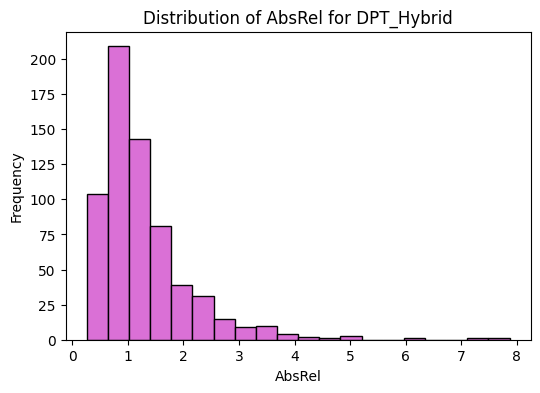

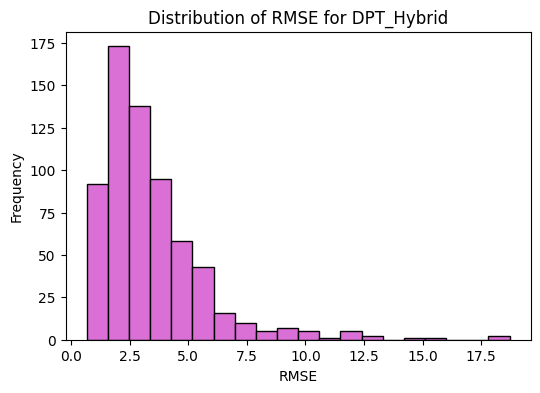

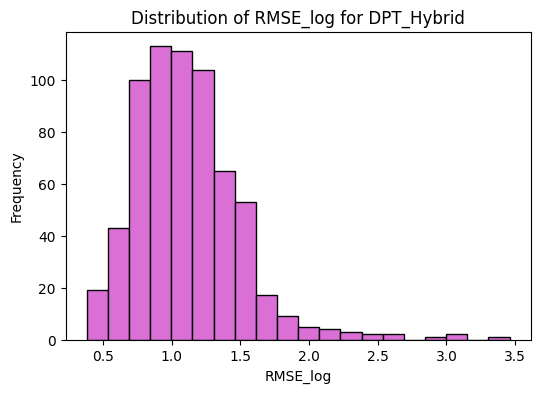

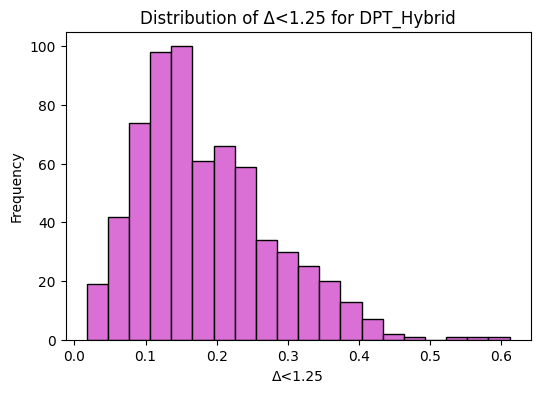

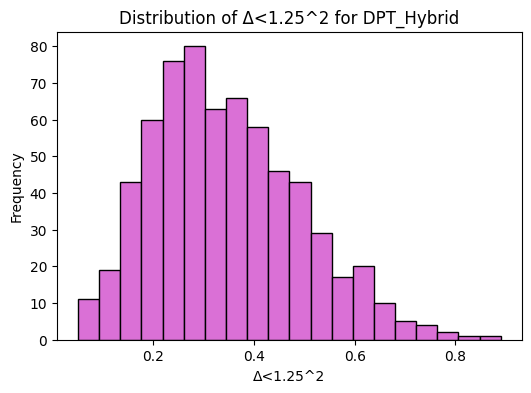

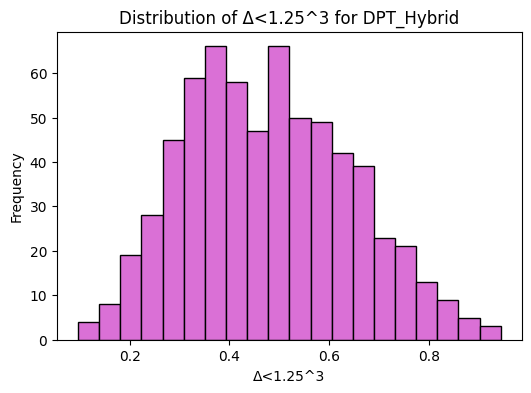

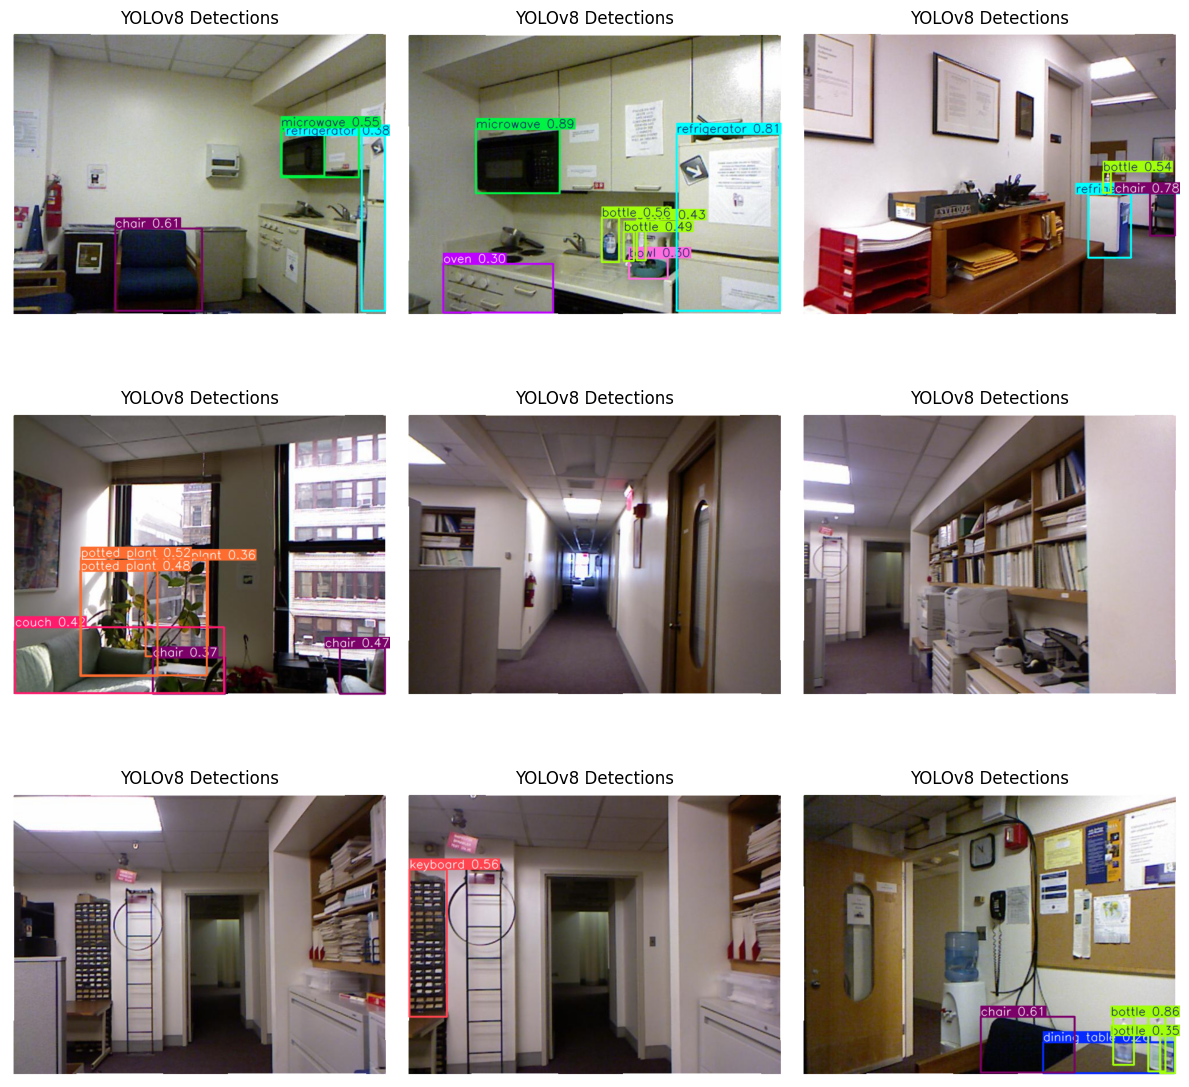

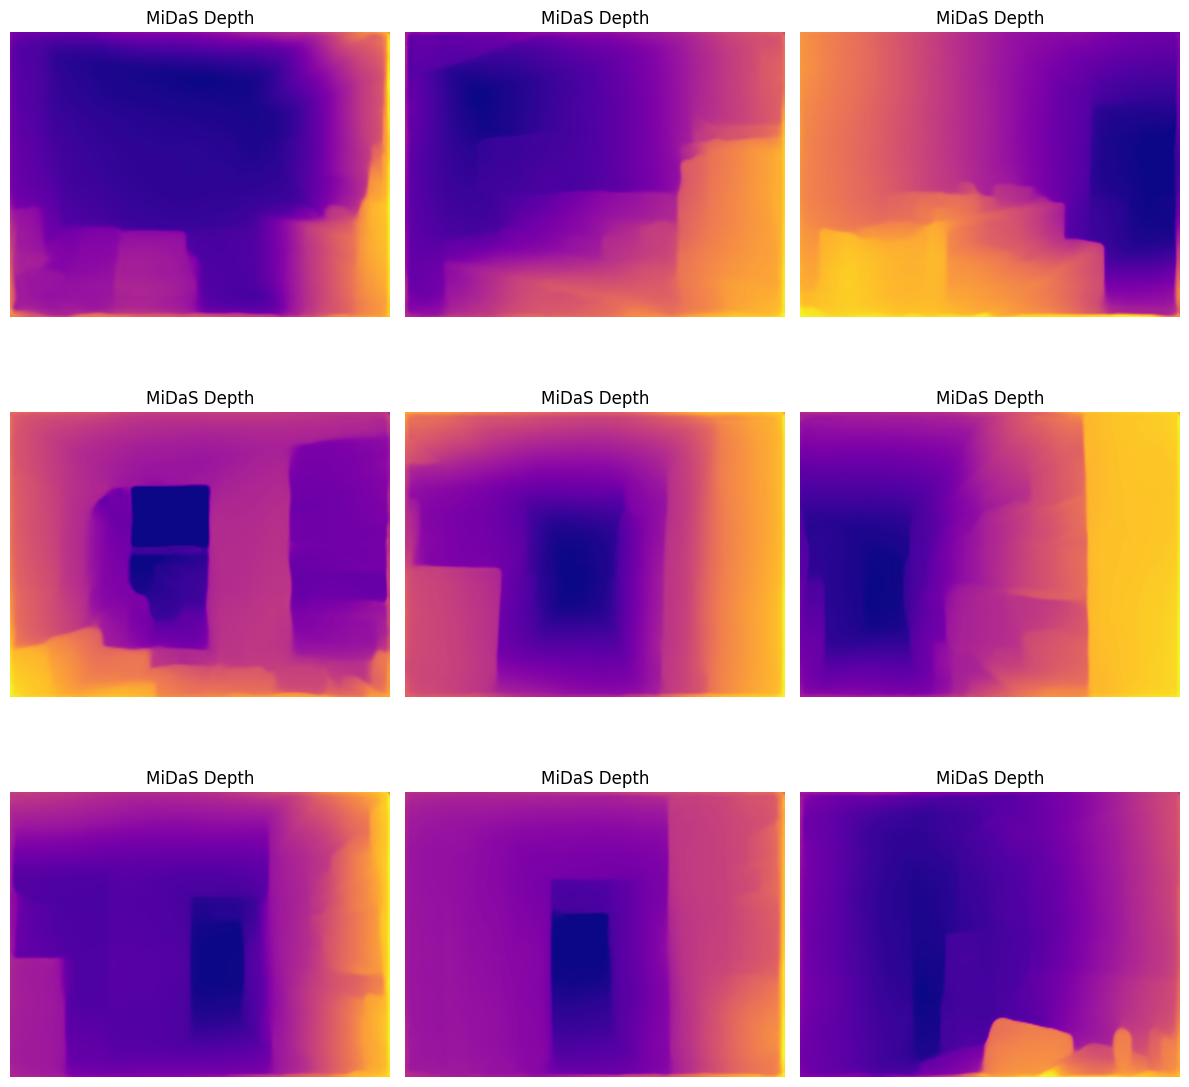

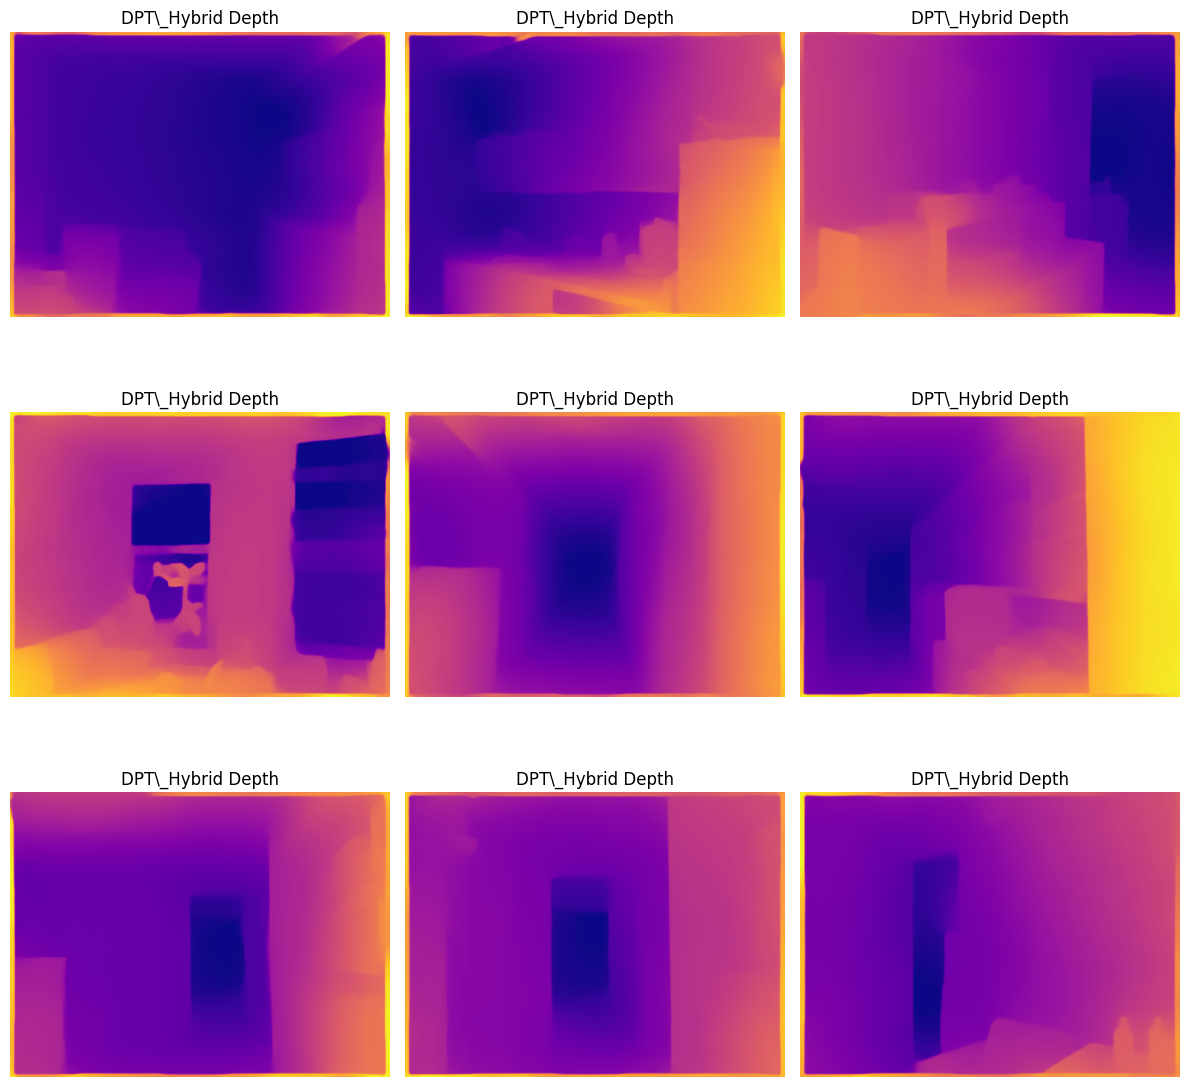

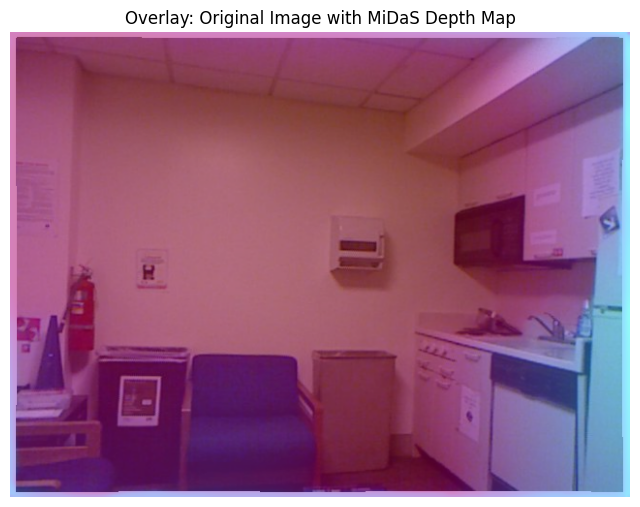

Summary of Average Depth Metrics:
        Model    AbsRel      RMSE  RMSE_log  Delta<1.25  Delta<1.25^2  \
0       MiDaS  1.226950  3.192290  1.365502    0.186241      0.344171   
1  DPT_Hybrid  1.284032  3.411108  1.112191    0.184736      0.345096   

   Delta<1.25^3  
0      0.479440  
1      0.478868  


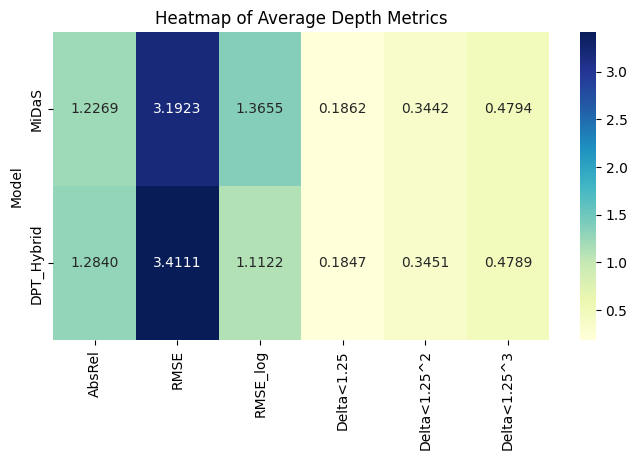

In [ ]:

# This notebook:
# - Loads the NYU Depth V2 test set from the extracted folder.
# - Runs inference using:
#     • YOLOv8 (latest from Ultralytics) for object detection.
#     • MiDaS_small and DPT_Hybrid (from the intel-isl/MiDaS repository) for depth estimation.
# - Computes robust depth metrics (AbsRel, RMSE, RMSE_log, delta accuracies) with median scaling.
# - Produces extended visualizations including bar charts, histograms, 3×3 grids of sample outputs,
#   overlay visualizations, and a summary table.

!pip install torch torchvision ultralytics opencv-python matplotlib seaborn



# %% [code]
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/archive.zip /content/
!unzip -q /content/archive.zip -d /content/nyu_data

import os
from PIL import Image
import torch
import torchvision.transforms as T
import numpy as np

class NYUTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform_img=None):
        self.root_dir = root_dir
        self.color_files = sorted([f for f in os.listdir(root_dir) if f.endswith("_colors.png")])
        self.transform_img = transform_img

    def __len__(self):
        return len(self.color_files)

    def __getitem__(self, idx):
        color_fname = self.color_files[idx]
        depth_fname = color_fname.replace("_colors", "_depth")
        color_path = os.path.join(self.root_dir, color_fname)
        depth_path = os.path.join(self.root_dir, depth_fname)
        image = Image.open(color_path).convert("RGB")
        depth = Image.open(depth_path)
        depth = np.array(depth).astype(np.float32) / 1000.0
        if self.transform_img:
            image = self.transform_img(image)
        else:
            image = T.ToTensor()(image)
        depth = torch.from_numpy(depth).unsqueeze(0)
        return image, depth


test_folder = "/content/nyu_data/data/nyu2_test"
if not os.path.isdir(test_folder):
    test_folder = "/content/nyu_data/nyu_data/data/nyu2_test"
    if not os.path.isdir(test_folder):
        raise FileNotFoundError("Test folder not found. Please check your archive structure.")
print(f"Using test folder: {test_folder}")


midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
midas_transform = midas_transforms.small_transform  # for MiDaS_small
dpt_transform = midas_transforms.dpt_transform       # for DPT_Hybrid

basic_transform = T.ToTensor()
dataset = NYUTestDataset(root_dir=test_folder, transform_img=basic_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
print(f"Loaded {len(dataset)} test samples.")


# Object Detection: YOLOv8 (nano version) from the ultralytics package.
# Depth Estimation: MiDaS_small and DPT_Hybrid from the intel-isl/MiDaS repository.

import torch
from ultralytics import YOLO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading YOLOv8 nano (pretrained)
yolo_model = YOLO("yolov8n.pt")
yolo_model.to(device)
yolo_model.model.eval()

# Loading depth estimation models:
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small").to(device)
midas.eval()
dpt_hybrid = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid", trust_repo=True).to(device)
dpt_hybrid.eval()


def compute_depth_metrics(gt, pred):
    mask = gt > 0
    gt_valid = gt[mask]
    pred_valid = pred[mask]
    scale = np.median(gt_valid) / (np.median(pred_valid) + 1e-6)
    pred_aligned = pred * scale
    pred_valid_aligned = pred_aligned[mask]
    abs_rel = np.mean(np.abs(gt_valid - pred_valid_aligned) / gt_valid)
    rmse = np.sqrt(np.mean((gt_valid - pred_valid_aligned) ** 2))
    rmse_log = np.sqrt(np.mean((np.log(gt_valid + 1e-6) - np.log(pred_valid_aligned + 1e-6)) ** 2))
    max_ratio = np.maximum(gt_valid/(pred_valid_aligned+1e-6), pred_valid_aligned/(gt_valid+1e-6))
    delta1 = np.mean(max_ratio < 1.25)
    delta2 = np.mean(max_ratio < 1.25**2)
    delta3 = np.mean(max_ratio < 1.25**3)
    return abs_rel, rmse, rmse_log, delta1, delta2, delta3


# For each sample in the test set:
# - Run YOLOv8 for object detection, record inference times, and store outputs from the first 9 samples.
# - Run depth estimation using MiDaS_small and DPT_Hybrid, record inference times, compute depth metrics, and store outputs from the first 9 samples.
#

import time
import matplotlib.pyplot as plt
import cv2

det_times = []         
det_samples = []       

depth_times = {"MiDaS": [], "DPT_Hybrid": []}
depth_metrics = {"MiDaS": [], "DPT_Hybrid": []}
depth_samples_midas = []     
depth_samples_dpt = []      


to_pil = T.ToPILImage()


for i, (img, gt_depth) in enumerate(data_loader):
    img = img.to(device)  # shape: [1, 3, H, W]

    # --- Object Detection using YOLOv8 ---
    t0 = time.time()
    pil_img = to_pil(img.squeeze(0).cpu())
    det_result = yolo_model(pil_img, verbose=False)
    t1 = time.time()
    det_times.append(t1 - t0)
    if i < 9:
        det_samples.append(det_result)

    # --- Depth Estimation ---
    # MiDaS_small:
    input_midas = midas_transform(np.array(pil_img)).to(device)
    t0 = time.time()
    pred_midas = midas(input_midas)
    t1 = time.time()
    depth_times["MiDaS"].append(t1 - t0)
    pred_midas = torch.nn.functional.interpolate(pred_midas.unsqueeze(1),
                                                 size=gt_depth.shape[-2:],
                                                 mode="bilinear",
                                                 align_corners=False).squeeze().detach().cpu().numpy()

    # DPT_Hybrid:
    input_dpt = dpt_transform(np.array(pil_img)).to(device)
    t0 = time.time()
    pred_dpt = dpt_hybrid(input_dpt)
    t1 = time.time()
    depth_times["DPT_Hybrid"].append(t1 - t0)
    pred_dpt = torch.nn.functional.interpolate(pred_dpt.unsqueeze(1),
                                               size=gt_depth.shape[-2:],
                                               mode="bilinear",
                                               align_corners=False).squeeze().detach().cpu().numpy()

    
    gt_depth_np = gt_depth.squeeze().cpu().numpy()
    met_midas = compute_depth_metrics(gt_depth_np, pred_midas)
    met_dpt = compute_depth_metrics(gt_depth_np, pred_dpt)
    depth_metrics["MiDaS"].append(met_midas)
    depth_metrics["DPT_Hybrid"].append(met_dpt)

    if i < 9:
        depth_samples_midas.append(pred_midas)
        depth_samples_dpt.append(pred_dpt)

avg_det_time = np.mean(det_times)
print(f"Avg YOLOv8 Detection Inference Time: {avg_det_time:.4f} s")

def average_metrics(metrics_list):
    return np.mean(np.array(metrics_list), axis=0)

avg_depth_times = {k: np.mean(v) for k, v in depth_times.items()}
avg_depth_metrics = {k: average_metrics(v) for k, v in depth_metrics.items()}

print("\nAvg Depth Inference Times:")
for k, v in avg_depth_times.items():
    print(f"{k}: {v:.4f} s")

print("\nAvg Depth Metrics (AbsRel, RMSE, RMSE_log, Δ<1.25, Δ<1.25^2, Δ<1.25^3):")
for k, v in avg_depth_metrics.items():
    print(f"{k}: {v}")


# The following visualizations are generated:
# - Bar charts for average inference times (object detection and depth estimation).
# - Bar charts for average depth metrics.
# - Histograms for YOLOv8 detection inference times and detection counts.
# - Histograms for each depth metric.
# - 3×3 grids of sample outputs for YOLOv8 detections and depth estimation.
# - Overlay visualization: blending the predicted depth map with the original RGB image.
# - A summary table (and heatmap) of the average depth metrics.

import pandas as pd
import seaborn as sns

# --- Bar Chart: Inference Times ---
plt.figure(figsize=(6,4))
plt.bar(["YOLOv8"], [avg_det_time], color="skyblue")
plt.ylabel("Time (s)")
plt.title("Avg YOLOv8 Detection Inference Time")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(list(avg_depth_times.keys()), list(avg_depth_times.values()), color=["salmon", "lightgreen"])
plt.ylabel("Time (s)")
plt.title("Avg Depth Estimation Inference Times")
plt.show()

# --- Bar Charts: Depth Metrics ---
metric_names = ["AbsRel", "RMSE", "RMSE_log", "Δ<1.25", "Δ<1.25^2", "Δ<1.25^3"]
for model_name in avg_depth_metrics:
    values = avg_depth_metrics[model_name]
    plt.figure(figsize=(6,4))
    plt.bar(metric_names, values, color="mediumpurple")
    plt.ylabel("Metric Value")
    plt.title(f"Avg Depth Metrics: {model_name}")
    plt.show()

# --- Histograms: YOLOv8 Detection Inference Times ---
plt.figure(figsize=(6,4))
plt.hist(det_times, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Inference Time (s)")
plt.ylabel("Frequency")
plt.title("Distribution of YOLOv8 Detection Inference Times")
plt.show()

# --- Histogram: Distribution of Detection Counts (if available) ---
det_counts = []
for det in det_samples:
    count = len(det[0].boxes) if hasattr(det[0], "boxes") else 0
    det_counts.append(count)
if det_counts:
    plt.figure(figsize=(6,4))
    plt.hist(det_counts, bins=range(0, max(det_counts)+2), color="lightgreen", edgecolor="black", align="left")
    plt.xlabel("Number of Detections")
    plt.ylabel("Frequency")
    plt.title("Distribution of Detections per Image (YOLOv8)")
    plt.show()

# --- Histograms for Depth Metrics ---
depth_metric_labels = ["AbsRel", "RMSE", "RMSE_log", "Δ<1.25", "Δ<1.25^2", "Δ<1.25^3"]
for model_name in depth_metrics:
    metrics_array = np.array(depth_metrics[model_name])
    for i, label in enumerate(depth_metric_labels):
        plt.figure(figsize=(6,4))
        plt.hist(metrics_array[:, i], bins=20, color="orchid", edgecolor="black")
        plt.xlabel(label)
        plt.ylabel("Frequency")
        plt.title(f"Distribution of {label} for {model_name}")
        plt.show()

# --- 3×3 Grid: Sample YOLOv8 Detection Outputs ---
def plot_detection_grid(det_samples):
    fig, axes = plt.subplots(3, 3, figsize=(12,12))
    for idx, det in enumerate(det_samples):
        detected_img = det[0].plot()  # returns image with detections (BGR)
        img_rgb = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
        row, col = idx // 3, idx % 3
        axes[row, col].imshow(img_rgb)
        axes[row, col].set_title("YOLOv8 Detections")
        axes[row, col].axis("off")
    plt.tight_layout()
    plt.show()

plot_detection_grid(det_samples)

# --- 3×3 Grid: Sample Depth Outputs ---
def plot_depth_grid(depth_samples, title):
    fig, axes = plt.subplots(3, 3, figsize=(12,12))
    for idx, depth_map in enumerate(depth_samples):
        row, col = idx // 3, idx % 3
        axes[row, col].imshow(depth_map, cmap="plasma")
        axes[row, col].set_title(title)
        axes[row, col].axis("off")
    plt.tight_layout()
    plt.show()

plot_depth_grid(depth_samples_midas, "MiDaS Depth")
plot_depth_grid(depth_samples_dpt, "DPT\_Hybrid Depth")

# --- Overlay Visualization: Blend Depth Map with Original Image ---
def overlay_depth_on_image(rgb_img, depth_map, alpha=0.6):
    norm_depth = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    depth_color = cv2.applyColorMap(norm_depth, cv2.COLORMAP_PLASMA)
    overlay = cv2.addWeighted(rgb_img, 1 - alpha, depth_color, alpha, 0)
    return overlay

sample_img_tensor, _ = next(iter(data_loader))
sample_img = sample_img_tensor.squeeze(0).permute(1,2,0).cpu().numpy() * 255
sample_img = sample_img.astype(np.uint8)
sample_depth_midas = depth_samples_midas[0]
overlay_img = overlay_depth_on_image(sample_img, sample_depth_midas, alpha=0.5)

plt.figure(figsize=(8,8))
plt.imshow(overlay_img)
plt.title("Overlay: Original Image with MiDaS Depth Map")
plt.axis("off")
plt.show()

# --- Summary Table of Depth Metrics ---
summary_data = []
for model_name in avg_depth_metrics:
    metrics = avg_depth_metrics[model_name]
    summary_data.append({
        "Model": model_name,
        "AbsRel": metrics[0],
        "RMSE": metrics[1],
        "RMSE_log": metrics[2],
        "Delta<1.25": metrics[3],
        "Delta<1.25^2": metrics[4],
        "Delta<1.25^3": metrics[5]
    })
df_summary = pd.DataFrame(summary_data)
print("Summary of Average Depth Metrics:")
print(df_summary)

plt.figure(figsize=(8,4))
sns.heatmap(df_summary.set_index("Model"), annot=True, cmap="YlGnBu", fmt=".4f")
plt.title("Heatmap of Average Depth Metrics")
plt.show()


